In [2]:
import os
import json
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt

In diesem Notebook wurden die Grafiken für den Vergleich der Normalisierungsverfahren erstellt.
Die aktuellen Versionen der hier verwendeten Funktionen und Klassen sind in den aufgesplitteten Notebooks und Skipten wie plot.ipynb oder history.ipynb zu finden.

In [3]:
class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params

def save_history(history, filename):
    with open('../histories/' + filename + '.json', 'wb') as file:
        model_history= History_trained_model(history.history, history.epoch, history.params)
        pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)
        
def load_history(filename):
    with open('../histories/' + filename + '.json', 'rb') as file:
        history=pickle.load(file)
    return history

def get_best_history(histories, unit, search):
    best_history = None
    for history in histories:
        if best_history is None:
            best_history = history
        if search == 'max':
            if np.amax(best_history.history[unit]) < np.amax(history.history[unit]):
                best_history = history
        elif search == 'max':
            if np.amax(best_history.history[unit]) > np.amin(history.history[unit]):
                best_history = history
    return best_history

def average_history(histories, template_name):
    histories_num = len(histories)
    #print(histories_num)
    length = len(histories[0].history['val_loss'])
    accuracy = np.zeros(length, dtype='float32')
    #recall = np.zeros(length, dtype='float32')
    #precision = np.zeros(length, dtype='float32')
    loss = np.zeros(length, dtype='float32')
    val_accuracy = np.zeros(length, dtype='float32')
    #val_recall = np.zeros(length, dtype='float32')
    #val_precision = np.zeros(length, dtype='float32')
    val_loss = np.zeros(length, dtype='float32')
    traintime = np.array([0], dtype="float32")
    
    for history in histories:
        traintime += history.history['traintime'][0]
        for i in range(length):
            accuracy[i] += history.history['accuracy'][i]
            #recall[i] += history.history['recall'][i]
            #precision[i] += history.history['precision'][i]
            loss[i] += history.history['loss'][i]
            val_accuracy[i] += history.history['val_accuracy'][i]
            #val_recall[i] += history.history['val_recall'][i]
            #val_precision[i] += history.history['val_precision'][i]
            val_loss[i] += history.history['val_loss'][i]
            
    traintime = traintime / histories_num 
    accuracy = accuracy / histories_num
    #recall = recall / histories_num
    #precision = precision / histories_num
    loss = loss / histories_num
    val_accuracy = val_accuracy / histories_num
    #val_recall = val_recall / histories_num
    #val_precision = val_precision / histories_num
    val_loss = val_loss / histories_num
    
    avg_history = load_history(template_name)
    avg_history.history['accuracy'] = list(accuracy)
    #avg_history.history['recall'] = list(recall)
    #avg_history.history['precision'] = list(recall)
    avg_history.history['loss'] = list(loss)
    avg_history.history['val_accuracy'] = list(val_accuracy)
    #avg_history.history['val_recall'] = list(val_recall)
    #avg_history.history['val_precision'] = list(recall)
    avg_history.history['val_loss'] = list(val_loss)
    avg_history.history['traintime'] = list(traintime)
    return avg_history

def plot_graph(metric, histories, labels, loc, titel, window=None):
    plt.figure(figsize=(4.6, 3.1), dpi=90)
    for i in range(len(histories)):
        plt.plot(histories[i].history[metric], label=labels[i])
    plt.title(titel)
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    legend = plt.legend(loc=loc, prop={'size':10})
    if window is not None:
        plt.ylim(top=window[1], bottom=window[0]) # displayed area
    plt.show()

def bar_plot(histories, labels, titel, search, unit, colors, window=None, min_loss=False):
    length = len(histories)
    values = np.zeros(length) 
    for i in range(length):
        if search == 'min':
            values[i] = np.amin(histories[i].history[unit])
        elif search == 'max':
            values[i] = np.amax(histories[i].history[unit])
    fig = plt.figure(figsize=(3.58,2.345), dpi=90)
    ax = fig.add_axes([0,0,1,1])
    plt.title(titel)
    plt.ylabel(unit)
    if unit == 'traintime':
        plt.ylabel('traintime in sec')
    labels = labels
    rects = ax.bar(labels, values, color=colors)
    print('values: ' + str(values))
    if window is not None:
        plt.ylim(top=window[1], bottom=window[0]) #ausschnitt der gezeigt wird, y Achse
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%g' % round(height, 3),
                ha='center', va='bottom')
    plt.show()
    
def bar_plot_loss_min(histories, labels, titel, unit, colors, window=None):
    length = len(histories)
    values = np.zeros(length)
    
    for i in range(length):
        min_loss_index = histories[i].history['val_loss'].index(np.amin(histories[i].history['val_loss']))
        values[i] = histories[i].history[unit][min_loss_index]
        
    fig = plt.figure(figsize=(3.58,2.345), dpi=90)
    ax = fig.add_axes([0,0,1,1])
    plt.title(titel)
    plt.ylabel(unit)
    if unit == 'traintime':
        plt.ylabel('traintime in sec')
    labels = labels
    rects = ax.bar(labels, values, color=colors)
    print('values: ' + str(values))
    if window is not None:
        plt.ylim(top=window[1], bottom=window[0]) #ausschnitt der gezeigt wird, y Achse
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%g' % round(height, 3),
                ha='center', va='bottom')
    plt.show()
    
def plot_directory(directory):
    histories = []
    labels = []
    for i in range(10):
        h = load_history(directory + '/' + str(i))
        print(directory + str(i) + ' - ' + str(h.history['traintime'][0]))
        #print(np.amin(h.history['val_loss']))
        histories.append(h)
        labels.append(str(i))
    plot_loss(histories,
              labels,
              directory)
    bar_plot(histories,
             labels,
             directory,
             'min',
             'val_loss')
    bar_plot(histories,
             labels,
             directory,
             'max',
             'traintime')
    
def load_histories_in_dir(directory):
    histories = []
    for i in range(num):
        h = load_history(directory + '/' + str(i))
        histories.append(h)
    return histories

def load_histories_from_folder(folder):
    histories = []
    for file in os.listdir('../histories/' + folder):
        path = '../histories/' + folder + '/' + file
        with open(path, 'rb') as file:
            h = pickle.load(file)
            histories.append(h)
    return histories

best norm: 0
best norm_minus: 20
best std: 20


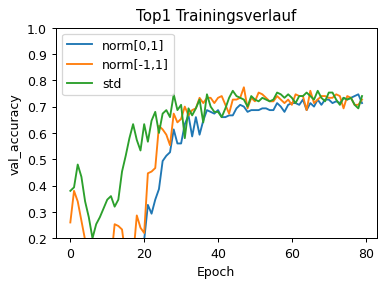

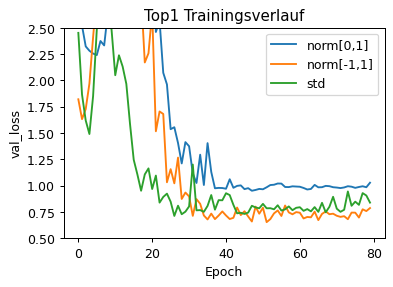

values: [0.74666667 0.77333331 0.75999999]


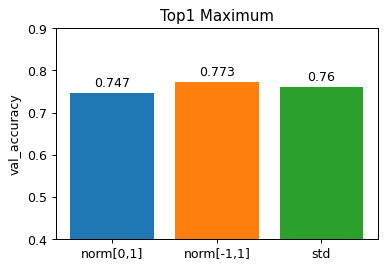

values: [0.95103568 0.65300351 0.71200061]


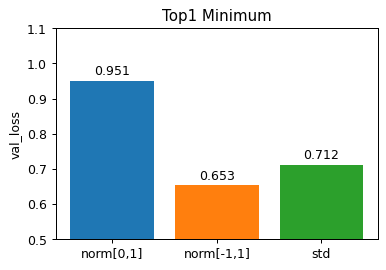

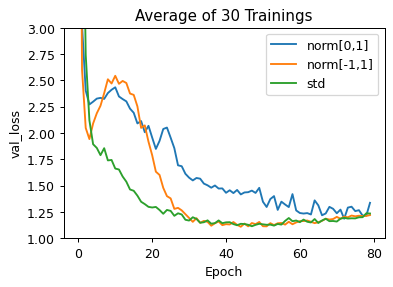

In [24]:
''' 
############### New Mels ################
gtzan_norm_10
Runs vom VM Training am 29.7/31.7
80 Epochen
Total params: 489,278
Trainable params: 488,910
'''
# the new 10 runs
folder = 'gtzan_norm_10'
#none10 = load_histories_from_folder(folder + '/none')
norm10 = load_histories_from_folder(folder + '/norm')
norm_minus10 = load_histories_from_folder(folder + '/norm-')
std10 = load_histories_from_folder(folder + '/std')

# the old 20 runs
#none = load_histories_from_folder('gtzan_norm/none')
norm = load_histories_from_folder('gtzan_norm/norm')
norm_minus = load_histories_from_folder('gtzan_norm/norm-')
std = load_histories_from_folder('gtzan_norm/std')

# combine
#none.extend(none10)
norm.extend(norm10)
norm_minus.extend(norm_minus10)
std.extend(std10)

# get best history
#best_none = get_best_history(none, 'val_accuracy', 'max')
#print('best none: ' + str(none.index(best_none)))
best_norm = get_best_history(norm, 'val_accuracy', 'max')
print('best norm: ' + str(norm.index(best_norm)))
best_norm_minus = get_best_history(norm_minus, 'val_accuracy', 'max')
print('best norm_minus: ' + str(norm_minus.index(best_norm_minus)))
best_std = get_best_history(std, 'val_accuracy', 'max')
print('best std: ' + str(std.index(best_std)))
best = []
#best.append(best_none)
best.append(best_norm)
best.append(best_norm_minus)
best.append(best_std)

labels = ['norm[0,1]', 'norm[-1,1]', 'std']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

avgs = []
history_template = 'gtzan_norm/std/std_0'
avg_norm = average_history(norm, history_template)
avgs.append(avg_norm)
avg_norm_minus = average_history(norm_minus, history_template)
avgs.append(avg_norm_minus)
avg_std = average_history(std, history_template)
avgs.append(avg_std)
# plot averages
plot_graph(
    'val_loss', avgs, labels, 'upper right',
    'Average of 30 Trainings', [1, 3])

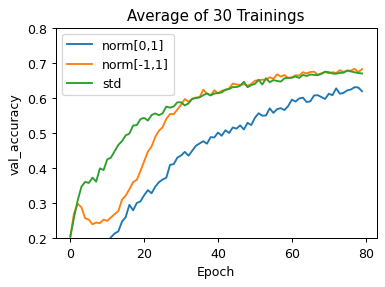

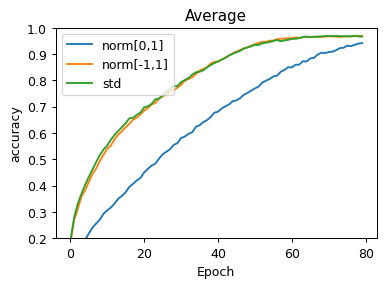

values: [1.18539488 1.10906935 1.11410475]


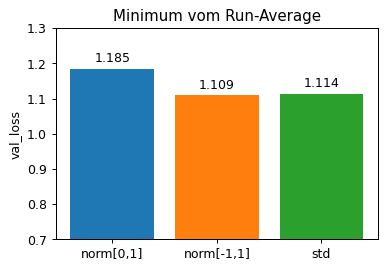

values: [0.63044447 0.68244445 0.6775555 ]


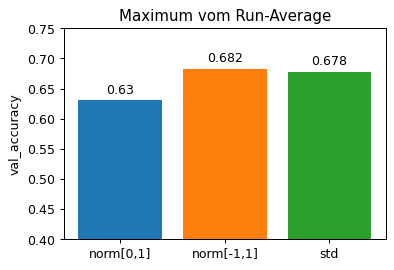

values: [0.62688899 0.64044446 0.64577782]


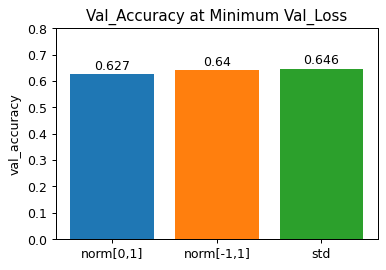

values: [220.79045105 219.17198181 220.4835968 ]


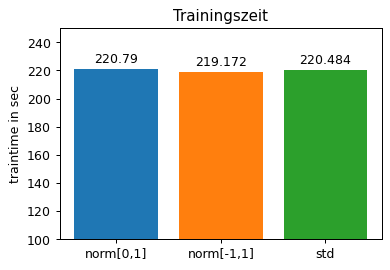

In [25]:
# plot averages
plot_graph(
    'val_accuracy', avgs, labels, 'upper left',
    'Average of 30 Trainings', [0.2, 0.8])
plot_graph(
    'accuracy', avgs, labels, 'upper left',
    'Average', [0.2, 1])
bar_plot(
    avgs, labels,'Minimum vom Run-Average', 'min',
    'val_loss', colors, [0.7, 1.3])
bar_plot(
    avgs, labels,'Maximum vom Run-Average', 'max',
    'val_accuracy', colors, [0.4, 0.75])
bar_plot_loss_min(
    avgs, labels,'Val_Accuracy at Minimum Val_Loss',
    'val_accuracy', colors, [0, 0.8])
bar_plot(
     avgs, labels, 'Trainingszeit', 'max',
     'traintime', colors, [100, 250])